In [1]:
import warnings
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import chisquare, expon, lognorm, norm, poisson, zipf, ks_2samp
import re
from collections import Counter, OrderedDict

warnings.filterwarnings('ignore')


In [2]:
def chisquare_test(sample, power=1.16, beta=3):
    unique, counts = np.unique(np.ceil(sample).astype(int), return_counts=True)
    counts[::-1].sort()

    frequencies = np.array([1.0 / np.power(i + beta, power) for i in range(1, len(counts) + 1)])
    zipf_counts = np.ceil(len(sample) * frequencies / frequencies.sum())
    
    return chisquare(counts, zipf_counts)[1]

def ks2_test(sample, power=1.16, beta=3):
    unique, counts = np.unique(np.ceil(sample).astype(int), return_counts=True)
    counts[::-1].sort()

    frequencies = np.array([1.0 / np.power(i + beta, power) for i in range(1, len(counts) + 1)])
    zipf_counts = np.ceil(len(sample) * frequencies / frequencies.sum()).astype(int)

    zipf_sample = []
    for i in range(len(counts)):
        zipf_sample.extend([i + 1 for j in range(zipf_counts[i])])

    return ks_2samp(sample, zipf_sample)[1]

tests = {'chi': chisquare_test,
         'ks2': ks2_test}


In [3]:
def add_noise(sample, level, distrib, args):
    rand_values = np.random.rand(len(sample))
    for i in range(len(sample)):
        if rand_values[i] < level:
            sample[i] = distrib.rvs(*args)


In [4]:
file = open('war_and_peace.txt', 'r')
text = file.read().lower()
words = re.sub('\W', ' ', text).split()[:500000]


In [5]:
def get_sample(words):
    word_counts = Counter(words)
    sorted_word_counts = sorted(word_counts.items(), key=lambda kv: -kv[1])
    sorted_word_counts = dict([(sorted_word_counts[i][0], i + 1) for i in range(len(sorted_word_counts))])
    return np.array([sorted_word_counts[word] for word in words])


# Baseline

In [6]:
pvalues_n = defaultdict(list)
sample_sizes = [i * 10000 for i in range(1, 51)]

for n in sample_sizes:
    sample = get_sample(words[:n])
    for name in tests:
        pvalues_n[name].append(tests[name](sample))


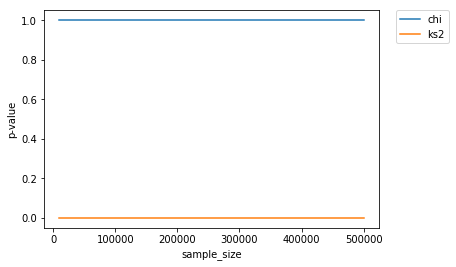

In [7]:
for name in tests:
    plt.plot(sample_sizes, pvalues_n[name], label=name)

plt.xlabel('sample_size')
plt.ylabel('p-value')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


In [8]:
pvalues_l = defaultdict(list)
num_blocks = 50
num_noise_levels = 30

noise_levels = [i / 100 for i in range(num_noise_levels)]
for name in tests:
    pvalues_l[name] = np.zeros(len(noise_levels))
word_blocks = np.split(np.array(words), num_blocks)

for k in range(num_blocks):
    orig_sample = get_sample(word_blocks[k])
    for i in range(num_noise_levels):
        sample = orig_sample.copy()
        add_noise(sample, noise_levels[i], lognorm, [1])
        for name in tests:
            pvalues_l[name][i] += tests[name](sample)

for name in tests:
    pvalues_l[name] /= num_blocks


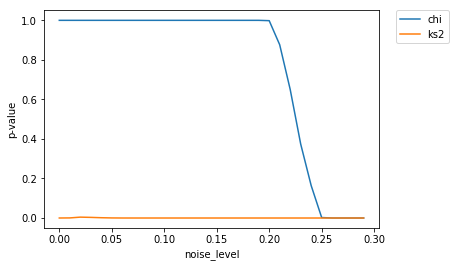

In [9]:
for name in tests:
    plt.plot(noise_levels, pvalues_l[name], label=name)
plt.xlabel('noise_level')
plt.ylabel('p-value')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


In [10]:
# type I errors
def get_false_positive(test, words, N=100):
    false_positive = 0;
    word_blocks = np.split(np.array(words), N)
    for i in range(N):
        sample = get_sample(word_blocks[k])
        if test(sample) <= 0.05:
            false_positive += 1
    return false_positive / N

# type II errors
def get_false_negative(test, N=1000, sample_size=1000, distrib=lognorm, args=[10]):
    true_negative = 0;
    for i in range(N):
        sample = distrib.rvs(*args, size=sample_size)
        if test(sample) > 0.05:
            true_negative += 1
    return true_negative / N


In [11]:
print('false_positive')
for name in tests:
    print(name, get_false_positive(tests[name], words))


false_positive
chi 0.0
ks2 1.0


In [12]:
print('false_negative')
for name in tests:
    print(name, get_false_negative(tests[name], distrib=lognorm, args=[0.1]))


false_negative
chi 0.042
ks2 0.0


# Distributed

## Hash

In [13]:
def hash_distributed_test(test, sample, paral_size=10):
    distributed_sample = defaultdict(list)
    for el in sample:
        distributed_sample[hash(str(el)) % paral_size].append(el)

    sum_pvalue = 0;
    for ds in distributed_sample:
        sum_pvalue += tests[name](get_sample(distributed_sample[ds]))

    return sum_pvalue


In [14]:
paral_sizes = [i for i in range(1, 20)]
pvalues = defaultdict(list)
sample = get_sample(words)
for name in tests:
    for ps in paral_sizes:
        pvalues[name].append(hash_distributed_test(tests[name], sample, paral_size=ps) / ps)


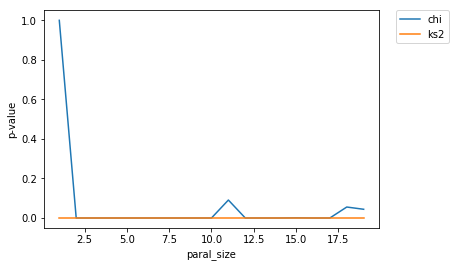

In [15]:
for name in tests:
    plt.plot(paral_sizes, pvalues[name], label=name)
plt.xlabel('paral_size')
plt.ylabel('p-value')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


## Round-robin

In [16]:
def round_distributed_test(test, sample, paral_size=10):
    distributed_sample = defaultdict(list)
    for i in range(len(sample)):
        distributed_sample[i % paral_size].append(sample[i])

    sum_pvalue = 0;
    for ds in distributed_sample:
        sum_pvalue += tests[name](get_sample(distributed_sample[ds]))

    return sum_pvalue


In [ ]:
paral_sizes = [i for i in range(1, 20)]
pvalues = defaultdict(list)
sample = get_sample(words)

for name in tests:
    for ps in paral_sizes:
        pvalues[name].append(round_distributed_test(tests[name], sample, paral_size=ps) / ps)


In [ ]:
for name in tests:
    plt.plot(paral_sizes, pvalues[name], label=name)
plt.xlabel('paral_size')
plt.ylabel('p-value')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
